#0. Library, load data

In [411]:
!pip install optuna

In [412]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score,recall_score,make_scorer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import optuna
import warnings
import torch
import torch.nn as nn
import torch.optim as optim
import os
from torch.utils.data import DataLoader, TensorDataset
import kagglehub

warnings.filterwarnings('ignore')

# loan_df = pd.read_csv('loan.csv')
# dict_df = pd.read_excel('Data_Dictionary.xlsx')

In [413]:
# Download latest version
path = kagglehub.dataset_download("abhishek14398/loan-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/abhishek14398/loan-dataset/versions/1


In [414]:
!ls $path

Data_Dictionary.xlsx  loan.csv


In [415]:
mainpath = path
data_dictionary_path =os.path.join(mainpath, 'Data_Dictionary.xlsx')
loan_path = os.path.join(mainpath, 'loan.csv')
loan_df = pd.read_csv(loan_path)
dict_df = pd.read_excel(data_dictionary_path)

#1. Data Understanding and Cleaning

In [416]:
loan_df.shape

(39717, 111)

In [417]:
loan_df.dtypes

,0
id,int64
member_id,int64
loan_amnt,int64
funded_amnt,int64
funded_amnt_inv,float64
...,...
tax_liens,float64
tot_hi_cred_lim,float64
total_bal_ex_mort,float64
total_bc_limit,float64


In [418]:
# Checking for Duplicate rows in the dataset.
print(loan_df.duplicated(subset=None,keep='first').count())

# The column used for checking is id column
duplicate_rows=loan_df[loan_df.duplicated(['id'])]
print("duplicate_rows :", duplicate_rows)

39717
duplicate_rows : Empty DataFrame
Columns: [id, member_id, loan_amnt, funded_amnt, funded_amnt_inv, term, int_rate, installment, grade, sub_grade, emp_title, emp_length, home_ownership, annual_inc, verification_status, issue_d, loan_status, pymnt_plan, url, desc, purpose, title, zip_code, addr_state, dti, delinq_2yrs, earliest_cr_line, inq_last_6mths, mths_since_last_delinq, mths_since_last_record, open_acc, pub_rec, revol_bal, revol_util, total_acc, initial_list_status, out_prncp, out_prncp_inv, total_pymnt, total_pymnt_inv, total_rec_prncp, total_rec_int, total_rec_late_fee, recoveries, collection_recovery_fee, last_pymnt_d, last_pymnt_amnt, next_pymnt_d, last_credit_pull_d, collections_12_mths_ex_med, mths_since_last_major_derog, policy_code, application_type, annual_inc_joint, dti_joint, verification_status_joint, acc_now_delinq, tot_coll_amt, tot_cur_bal, open_acc_6m, open_il_6m, open_il_12m, open_il_24m, mths_since_rcnt_il, total_bal_il, il_util, open_rv_12m, open_rv_24m, ma

In [419]:
# Check duplicated data
loan_df.duplicated().sum()

0

In [420]:
# Delete completely empty columns
loan_df = loan_df.dropna(axis=1, how='all')

In [421]:
# Finding number of rows through sum function which have missing values
print('Number of rows having all values as null:')
print(loan_df.isnull().all(axis=1).sum())

# Finding the number of columns through sum function which have missing values

print('Number of columns having all values as null:')
print(loan_df.isnull().all(axis=0).sum())

Number of rows having all values as null:
0
Number of columns having all values as null:
0


In [422]:
# Inconsistencies data
numeric = loan_df.select_dtypes(include=np.number)
(numeric.values < 0).sum()

0

In [423]:
# Loại bỏ ký hiệu % trong cột 'int_rate' và 'revol_util' để thêm vào trong phân tích
loan_df['int_rate'] = loan_df['int_rate'].str.rstrip('%').astype(float)
loan_df['revol_util'] = loan_df['revol_util'].str.rstrip('%').astype(float)

In [424]:
loan_df['emp_length']=loan_df.emp_length.str.extract('(\d+)')
# Chuyển đổi các cột dữ liệu số thành kiểu numeric
columns1=['loan_amnt','funded_amnt','int_rate','funded_amnt_inv','installment','annual_inc','dti','emp_length','total_pymnt']
loan_df[columns1]=loan_df[columns1].apply(pd.to_numeric)

In [425]:
# Loại bỏ giá trị 'Current' trong cột 'loan_status' do vẫn còn trong thời hạn mượn nợ
loan_df = loan_df[loan_df.loan_status != "Current"]

In [426]:
loan_df.loan_status.value_counts()

,count
loan_status,
Fully Paid,32950
Charged Off,5627


In [427]:
# Điền giá trị 0 cho các dòng Null trong cột 'pub_rec_bankruptcies'
loan_df['pub_rec_bankruptcies'].fillna(0, inplace = True)

In [428]:
loan_df['pub_rec_bankruptcies'].isnull().sum()

0

In [429]:
# Tính tỷ lệ giá trị thiếu cho mỗi cột
missing_values = loan_df.isnull().mean() * 100

# Xác định các cột có tỷ lệ giá trị thiếu lớn hơn 10%
cols_to_drop = missing_values[missing_values > 10].index

# Xóa các cột này khỏi DataFrame
loan_df = loan_df.drop(columns=cols_to_drop)

# Hiển thị các cột đã bị xóa
print(f"Các cột đã bị xóa: {cols_to_drop.tolist()}")

Các cột đã bị xóa: ['desc', 'mths_since_last_delinq', 'mths_since_last_record', 'next_pymnt_d']


In [430]:
# Impute missing values using IterativeImputer
imputer = IterativeImputer(random_state=100, max_iter=10)
# fit on the dataset
df2 = loan_df.select_dtypes(exclude= 'object')
imputer.fit(df2)
df_imputed = imputer.transform(df2)
df_imputed[:10]
df_imputed = pd.DataFrame(df_imputed, columns=df2.columns)
df = loan_df.drop(columns=df2.columns)
loan_df = pd.concat([df_imputed, df], axis=1)

In [431]:
# Boxplot outliers
numeric = pd.melt(numeric, var_name='Column', value_name='Value')
sns.boxplot(data=numeric, x='Column', y='Value')
plt.title("Boxplot for Numerical Column before Outlier Treatment")
plt.xticks(rotation=90)
plt.show()

In [432]:
loan_df.describe()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,emp_length,annual_inc,dti,...,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,policy_code,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens
count,3.857700e+04,3.857700e+04,38577.000000,38577.000000,38577.000000,38577.000000,38577.000000,38577.000000,3.857700e+04,38577.000000,...,38577.000000,38577.000000,38577.000000,38577.0,38577.0,38577.0,38577.0,38577.0,38577.000000,38577.0
mean,6.763787e+05,8.422843e+05,11047.025430,10784.058506,10222.481123,11.932219,322.466318,5.063208,6.877797e+04,13.272727,...,98.035545,12.772728,2746.243218,0.0,1.0,0.0,0.0,0.0,0.042694,0.0
std,2.092639e+05,2.644519e+05,7348.441646,7090.306027,7022.720644,3.691327,208.639215,3.359042,6.421868e+04,6.673044,...,698.650182,150.836853,4494.648131,0.0,0.0,0.0,0.0,0.0,0.202809,0.0
min,5.473400e+04,7.069900e+04,500.000000,500.000000,0.000000,5.420000,15.690000,1.000000,4.000000e+03,0.000000,...,0.000000,0.000000,0.000000,0.0,1.0,0.0,0.0,0.0,0.000000,0.0
25%,5.120330e+05,6.611310e+05,5300.000000,5200.000000,5000.000000,8.940000,165.740000,2.000000,4.000000e+04,8.130000,...,0.000000,0.000000,217.420000,0.0,1.0,0.0,0.0,0.0,0.000000,0.0
50%,6.564230e+05,8.392920e+05,9600.000000,9550.000000,8733.440000,11.710000,277.860000,4.000000,5.886800e+04,13.370000,...,0.000000,0.000000,568.260000,0.0,1.0,0.0,0.0,0.0,0.000000,0.0
75%,8.291460e+05,1.037336e+06,15000.000000,15000.000000,14000.000000,14.380000,425.550000,9.000000,8.200000e+04,18.560000,...,0.000000,0.000000,3447.250000,0.0,1.0,0.0,0.0,0.0,0.000000,0.0
max,1.077501e+06,1.314167e+06,35000.000000,35000.000000,35000.000000,24.400000,1305.190000,10.000000,6.000000e+06,29.990000,...,29623.350000,7002.190000,36115.200000,0.0,1.0,0.0,0.0,0.0,2.000000,0.0


In [433]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Calculate bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Remove rows where the value is outside the bounds
    df_cleaned = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    return df_cleaned

In [434]:
# Do cột 'annual_inc' có nhiều giá trị ngoại lai nên ta sẽ remove
loan_df = remove_outliers(loan_df, 'annual_inc')

#2. Feature selection & visualization

In [435]:
numeric = pd.melt(loan_df.select_dtypes(exclude = 'object'), var_name = 'Column', value_name = 'Value')
sns.boxplot(data=numeric, x='Column', y='Value') # Use the loan_df DataFrame that includes 'Column' and 'Value'
plt.title("Boxplot for Numerical Column after Outlier Treatment")
plt.xticks(rotation=90) # Rotate x-axis labels for better readability if needed
plt.show()

In [436]:
loan_df.describe()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,emp_length,annual_inc,dti,...,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,policy_code,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens
count,3.681500e+04,3.681500e+04,36815.000000,36815.000000,36815.000000,36815.000000,36815.000000,36815.000000,36815.000000,36815.000000,...,36815.000000,36815.000000,36815.000000,36815.0,36815.0,36815.0,36815.0,36815.0,36815.000000,36815.0
mean,6.760857e+05,8.419800e+05,10706.984925,10460.175200,9916.487115,11.889882,312.593015,5.026362,61218.193490,13.437614,...,95.148365,12.176062,2634.677276,0.0,1.0,0.0,0.0,0.0,0.043787,0.0
std,2.091882e+05,2.643366e+05,7068.107909,6820.737715,6750.340900,3.668709,199.806808,3.347519,28224.583784,6.660651,...,680.688516,145.441890,4313.178379,0.0,0.0,0.0,0.0,0.0,0.205285,0.0
min,5.473400e+04,7.472400e+04,500.000000,500.000000,0.000000,5.420000,15.690000,1.000000,4000.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,1.0,0.0,0.0,0.0,0.000000,0.0
25%,5.122775e+05,6.614220e+05,5000.000000,5000.000000,4988.984523,8.940000,163.305000,2.000000,40000.000000,8.340000,...,0.000000,0.000000,212.730000,0.0,1.0,0.0,0.0,0.0,0.000000,0.0
50%,6.556460e+05,8.378840e+05,9250.000000,9000.000000,8400.000000,11.710000,271.140000,4.000000,56000.000000,13.570000,...,0.000000,0.000000,546.160000,0.0,1.0,0.0,0.0,0.0,0.000000,0.0
75%,8.278755e+05,1.035967e+06,15000.000000,14400.000000,13687.858570,14.270000,409.700000,8.000000,78000.000000,18.700000,...,0.000000,0.000000,3312.680000,0.0,1.0,0.0,0.0,0.0,0.000000,0.0
max,1.077501e+06,1.314167e+06,35000.000000,35000.000000,35000.000000,24.400000,1305.190000,10.000000,145000.000000,29.990000,...,29623.350000,7002.190000,36115.200000,0.0,1.0,0.0,0.0,0.0,2.000000,0.0


In [437]:
# Tính phần trăm dựa vào mục đích vay
(loan_df.purpose.value_counts()*100)/len(loan_df)

,count
purpose,
debt_consolidation,45.476029
credit_card,12.614423
other,9.542306
home_improvement,7.266060
major_purchase,5.508624
small_business,4.400380
car,3.805514
wedding,2.319707
medical,1.727557


In [438]:
# Do Feature Selection
unnecessary_column = ["application_type","policy_code","initial_list_status","installment","pymnt_plan"]
loan_df.drop(labels = unnecessary_column,axis = 1,inplace = True)
print(loan_df.shape)
loan_df.isnull().sum()

(36815, 48)


,0
id,0
member_id,0
loan_amnt,0
funded_amnt,0
funded_amnt_inv,0
int_rate,0
emp_length,0
annual_inc,0
dti,0
delinq_2yrs,0


In [439]:
# Bỏ các cột addr_state, grade, url vì các dữ liệu không ảnh hưởng đến việc dự đoán
columns_to_drop = ['addr_state', 'grade', 'url']
loan_df = loan_df.drop(columns=[col for col in columns_to_drop if col in loan_df.columns])

In [440]:
numerical_features = loan_df.select_dtypes(exclude = 'object').columns
# Plot distributions
num_features = len(numerical_features)
num_cols = 5
num_rows = (num_features // num_cols) + (num_features % num_cols > 0)

plt.figure(figsize=(20, 15))
for i, feature in enumerate(numerical_features):
    plt.subplot(num_rows, num_cols, i + 1)
    sns.histplot(loan_df[feature], kde=True)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

In [441]:
# Bỏ các cột out_prncp, out_prncp_inv, chargeoff_within_12_mths, delinq_amnt, tax_liens vì các giá trị không đổi
columns_to_drop = ['out_prncp', 'out_prncp_inv', 'chargeoff_within_12_mths', 'delinq_amnt', 'tax_liens']
loan_df = loan_df.drop(columns=[col for col in columns_to_drop if col in loan_df.columns])

In [442]:
loan_df.shape

(36815, 40)

In [443]:
# Label Encoding for binary categorical columns
label_encoder = LabelEncoder()
binary_cols = loan_df.select_dtypes(include=['object']).columns.intersection(['term', 'sub_grade', 'home_ownership',
                                                                             'verification_status', 'issue_d',
                                                                             'purpose', 'title', 'zip_code',
                                                                             'earliest_cr_line',
                                                                             'last_pymnt_d', 'last_credit_pull_d', 'emp_title'])
for col in binary_cols:
    loan_df[col] = label_encoder.fit_transform(loan_df[col])

for col in binary_cols:
    freq_encoding = loan_df[col].value_counts().to_dict()
    loan_df[col] = loan_df[col].map(freq_encoding)

- Thay giá trị 'Fully Paid' = 1, 'Charged Off' = 0 do nếu 1 người trả nợ thì có thể tiếp tục cho mượn và ngược lại.
- Nên lấy loan_status làm cột target cho model.

In [444]:
loan_df['loan_status'] = loan_df['loan_status'].map({'Fully Paid': 1, 'Charged Off': 0})

In [445]:
# Điền các giá trị trống bằng giá trị median
loan_df = loan_df.fillna(loan_df.median())

In [446]:
# Assuming 'loan_status' is the column indicating loan acceptance/rejection
# Encode 'loan_status' if it's categorical
loan_df['loan_status'] = loan_df['loan_status'].apply(lambda x: 1 if x == 1.0 else 0)

# Calculate the correlation matrix
correlation_matrix = loan_df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.1f')
plt.title('Correlation Matrix')
plt.show()

- Từ hình ta thấy được sự tương quan giữa các feature với nhau, các feature có sự tương quan lớn nên có loại bỏ được 1 trong 2.

In [447]:
# Loại bỏ các cột có độ tương quan cao
columns_to_drop = ['member_id', 'funded_amnt_inv', 'total_pymnt_inv', 'issue_d']
loan_df = loan_df.drop(columns=[col for col in columns_to_drop if col in loan_df.columns])

In [448]:
# Count different values for loan_status
loan_status_counts = loan_df['loan_status'].value_counts()

# Print the counts
print("Class Distribution of Loan Status:")
print(loan_status_counts)

# Plot the class distribution
plt.figure(figsize=(8, 6))
loan_status_counts.plot(kind='bar')
plt.title('Class Distribution of Loan Status')
plt.xlabel('Loan Status')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

Class Distribution of Loan Status:
loan_status
1    31627
0     5188
Name: count, dtype: int64


In [449]:
numerical_features = loan_df.drop(columns=['id', 'collections_12_mths_ex_med', 'acc_now_delinq']).select_dtypes(include=np.number).columns

# Plot distributions
num_features = len(numerical_features)
num_cols = 5
num_rows = (num_features // num_cols) + (num_features % num_cols > 0)

plt.figure(figsize=(20, 15))
for i, feature in enumerate(numerical_features):
    plt.subplot(num_rows, num_cols, i + 1)
    sns.histplot(loan_df[feature], kde=True)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

In [450]:
loan_df.shape

(36815, 36)

1. **Class Distribution**:
   - Analyze the balance of accepted vs. rejected loans được thực hiện bằng cách đếm số lần xuất hiện của Fully paid và Charged off.
   - Vẽ biểu đồ cột để trực quan hóa loan_status.

2. **Feature Distributions**:
   - Vẽ các biểu đồ cột thể hiện sự phân bố dữ liệu của từng feature. Từ đó, tập trung vào các feature có mật độ phân bố trải đều, ổn định như: dti, annual_inc, total_pymnt, total_acc...

3. **Correlation Analysis**:
   - Vẽ biểu đồ nhiệt để thể hiện sự tương quan của features qua correlation matrix, loại bỏ các feature có độ tương quan lớn.

4. **Missing Values**:
   - Dựa vào phần trăm các giá trị bị thiếu để lựa chọn feature phù hợp cho mô hình.
   - Giữ lại các feature có phần trăm thiếu sót dưới 10% do các feature có ít sự liên kết với nhau.
   - Điền các giá trị thiếu bằng 2 cách:
      - Đối với numeric_features: sử dụng mô hình MICE để dự đoán.
      - Đối với categorical variables: encoding dữ liệu sau đó điền giá trị bị thiếu bằng median.

In [451]:
# create the scaler
ss = StandardScaler()

# fit and transform the data
loan_df_scaled = ss.fit_transform(loan_df.select_dtypes(exclude= 'object'))

In [452]:
# Assuming loan_df is your DataFrame and 'loan_status' is the target variable

# 1. Prepare the data
X = loan_df.drop(columns=['loan_status','id', 'collections_12_mths_ex_med','acc_now_delinq'])  # Features
y = loan_df['loan_status']  # Target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

#II Model Development

Decision Tree

In [453]:
# Create the Decision Tree model with class weight to minimize false positives
dt_model = DecisionTreeClassifier(class_weight='balanced', random_state=42)

# Train the model
dt_model.fit(X_train, y_train)

y_val_pred = dt_model.predict(X_val)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_val, y_val_pred))
print("ROC AUC Score:")
print(roc_auc_score(y_val, y_val_pred))

Confusion Matrix:
[[ 245  475]
 [ 500 3934]]

Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.34      0.33       720
           1       0.89      0.89      0.89      4434

    accuracy                           0.81      5154
   macro avg       0.61      0.61      0.61      5154
weighted avg       0.81      0.81      0.81      5154


Accuracy Score:
0.810826542491269
ROC AUC Score:
0.6137563900165388


In [454]:
# Predict on the validation set
y_test_pred = dt_model.predict(X_test)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_test_pred))
print("ROC AUC Score:")
print(roc_auc_score(y_test, y_test_pred))

Confusion Matrix:
[[ 512 1051]
 [1091 8391]]

Classification Report:
              precision    recall  f1-score   support

           0       0.32      0.33      0.32      1563
           1       0.89      0.88      0.89      9482

    accuracy                           0.81     11045
   macro avg       0.60      0.61      0.61     11045
weighted avg       0.81      0.81      0.81     11045


Accuracy Score:
0.8060660932548664
ROC AUC Score:
0.6062575310218384


HyperTunning

In [455]:
# Hàm mục tiêu
def objective(trial):
    # Tham số để tối ưu hóa
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])

    # Mô hình Decision Tree
    dt_model = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        criterion=criterion,
        random_state=42,
        class_weight='balanced'
    )

    # Tính Recall của lớp 0 với Cross-Validation
    recall_scores = cross_val_score(
        dt_model, X_train, y_train,
        cv=5, scoring=make_scorer(recall_score, pos_label=0)
    )

    # Trả về Recall trung bình
    return recall_scores.mean()

In [456]:
study = optuna.create_study(direction='maximize')  # Tối đa hóa Recall lớp 0
study.optimize(objective, n_trials=50)  # Thử nghiệm 50 lần

# Kết quả tốt nhất
print("Best parameters:", study.best_params)
print("Best recall for class 0:", study.best_value)

[I 2024-11-29 16:12:42,579] A new study created in memory with name: no-name-fc35ae18-5274-4efb-a057-bf638d8dfaca
[I 2024-11-29 16:12:44,647] Trial 0 finished with value: 0.559380378657487 and parameters: {'max_depth': 14, 'min_samples_split': 11, 'min_samples_leaf': 2, 'criterion': 'gini'}. Best is trial 0 with value: 0.559380378657487.
[I 2024-11-29 16:12:46,141] Trial 1 finished with value: 0.6371772805507745 and parameters: {'max_depth': 9, 'min_samples_split': 4, 'min_samples_leaf': 2, 'criterion': 'gini'}. Best is trial 1 with value: 0.6371772805507745.
[I 2024-11-29 16:12:48,854] Trial 2 finished with value: 0.5676419965576591 and parameters: {'max_depth': 14, 'min_samples_split': 4, 'min_samples_leaf': 4, 'criterion': 'gini'}. Best is trial 1 with value: 0.6371772805507745.
[I 2024-11-29 16:12:51,353] Trial 3 finished with value: 0.5975903614457831 and parameters: {'max_depth': 12, 'min_samples_split': 4, 'min_samples_leaf': 8, 'criterion': 'entropy'}. Best is trial 1 with valu

Best parameters: {'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 10, 'criterion': 'gini'}
Best recall for class 0: 0.6602409638554217


In [457]:
best_params = study.best_params
dt_model = DecisionTreeClassifier(
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    criterion=best_params['criterion'],
    class_weight='balanced',
    random_state=42
)

dt_model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=8,
                       min_samples_leaf=10, min_samples_split=8,
                       random_state=42)

In [458]:
y_train_pred = dt_model.predict(X_train)
print("Train Set:")
print("Confusion Matrix:")
print(confusion_matrix(y_train, y_train_pred))
print("\nClassification Report:")
print(classification_report(y_train, y_train_pred))

Train Set:
Confusion Matrix:
[[ 2166   739]
 [ 4335 13376]]

Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.75      0.46      2905
           1       0.95      0.76      0.84     17711

    accuracy                           0.75     20616
   macro avg       0.64      0.75      0.65     20616
weighted avg       0.86      0.75      0.79     20616



In [459]:
# Predict on the validation set
y_val_pred=dt_model.predict(X_val)
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_val, y_val_pred))
print("ROC AUC Score:")
print(roc_auc_score(y_val, y_val_pred))
# Predict on the test set
y_test_pred = dt_model.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_test_pred))
print("ROC AUC Score:")
print(roc_auc_score(y_test, y_test_pred))



Classification Report:
              precision    recall  f1-score   support

           0       0.28      0.64      0.39       720
           1       0.93      0.74      0.82      4434

    accuracy                           0.72      5154
   macro avg       0.61      0.69      0.61      5154
weighted avg       0.84      0.72      0.76      5154


Accuracy Score:
0.7246798603026775
ROC AUC Score:
0.6887498120583371

Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.65      0.40      1563
           1       0.93      0.74      0.82      9482

    accuracy                           0.72     11045
   macro avg       0.61      0.69      0.61     11045
weighted avg       0.84      0.72      0.76     11045


Accuracy Score:
0.7248528746038931
ROC AUC Score:
0.6936091186951794


Feature Selection

In [460]:
# Lấy trọng số của từng feature
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': dt_model.feature_importances_
}).sort_values(by='Importance', ascending=False)
# Hiển thị các đặc trưng quan trọng
print("Feature Importances:")
print(feature_importances.head(20))


Feature Importances:
               Feature  Importance
30        last_pymnt_d    0.339652
31  last_credit_pull_d    0.242848
22           sub_grade    0.143824
21                term    0.123114
19     last_pymnt_amnt    0.017597
28            zip_code    0.017541
2             int_rate    0.014219
5                  dti    0.012111
29    earliest_cr_line    0.011309
23           emp_title    0.010401
11          revol_util    0.008786
24      home_ownership    0.007826
1          funded_amnt    0.005974
12           total_acc    0.005922
4           annual_inc    0.005896
10           revol_bal    0.005594
26             purpose    0.004202
13         total_pymnt    0.004200
14     total_rec_prncp    0.003822
8             open_acc    0.003652


In [461]:
threshold =0.03
selected_features = feature_importances[feature_importances['Importance'] > threshold]
selected_features

,Feature,Importance
30,last_pymnt_d,0.339652
31,last_credit_pull_d,0.242848
22,sub_grade,0.143824
21,term,0.123114


In [465]:
X_val_selected_dict = {}

In [463]:
# Lấy danh sách các feature từ selected_features
selected_feature_names = selected_features['Feature'].tolist()

# Lọc X_train chỉ giữ lại các feature trong selected_feature_names
X_train_selected = X_train[selected_feature_names]
X_val_selected = X_val[selected_feature_names]
X_test_selected = X_test[selected_feature_names]

# Hiển thị các cột đã được chọn
print(X_train_selected.columns)

Index(['last_pymnt_d', 'last_credit_pull_d', 'sub_grade', 'term'], dtype='object')


In [466]:
X_val_selected_dict["decision tree"] = X_val_selected

In [467]:
# Train the model
dt_model.fit(X_train_selected, y_train)

y_val_pred = dt_model.predict(X_val_selected)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_val, y_val_pred))
print("ROC AUC Score:")
print(roc_auc_score(y_val, y_val_pred))

Confusion Matrix:
[[ 479  241]
 [1043 3391]]

Classification Report:
              precision    recall  f1-score   support

           0       0.31      0.67      0.43       720
           1       0.93      0.76      0.84      4434

    accuracy                           0.75      5154
   macro avg       0.62      0.72      0.63      5154
weighted avg       0.85      0.75      0.78      5154


Accuracy Score:
0.7508731082654249
ROC AUC Score:
0.7150249962411668


In [468]:
y_test_pred = dt_model.predict(X_test_selected)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_test_pred))
print("ROC AUC Score:")
print(roc_auc_score(y_test, y_test_pred))

Confusion Matrix:
[[1072  491]
 [2284 7198]]

Classification Report:
              precision    recall  f1-score   support

           0       0.32      0.69      0.44      1563
           1       0.94      0.76      0.84      9482

    accuracy                           0.75     11045
   macro avg       0.63      0.72      0.64     11045
weighted avg       0.85      0.75      0.78     11045


Accuracy Score:
0.7487550928021729
ROC AUC Score:
0.7224915363088873


Logistic Regression Model

In [297]:
logistic_model = LogisticRegression(class_weight='balanced', random_state=42, penalty='l2', solver='liblinear')

logistic_model.fit(X_train, y_train)

y_val_pred = logistic_model.predict(X_val)
print("Validation Set:")
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_val, y_val_pred))
print("ROC AUC Score:")
print(roc_auc_score(y_val, y_val_pred))

Validation Set:
Confusion Matrix:
[[ 449  271]
 [1488 2946]]

Classification Report:
              precision    recall  f1-score   support

           0       0.23      0.62      0.34       720
           1       0.92      0.66      0.77      4434

    accuracy                           0.66      5154
   macro avg       0.57      0.64      0.55      5154
weighted avg       0.82      0.66      0.71      5154


Accuracy Score:
0.6587116802483508
ROC AUC Score:
0.644011238911442


HyperTunning

In [298]:
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [100, 200, 300],
    'class_weight': ['balanced']
}

In [299]:
# Tạo đối tượng LogisticRegression
model = LogisticRegression()

# Sử dụng GridSearchCV để tìm các tham số tốt nhất
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring=make_scorer(recall_score,pos_label=0),cv=5, n_jobs=-1)

# Huấn luyện mô hình
grid_search.fit(X_train, y_train)

# In ra các tham số tốt nhất
print("Best parameters found: ", grid_search.best_params_)

Best parameters found:  {'C': 0.1, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}


In [300]:
# Dự đoán và đánh giá mô hình
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy Score:")
print(accuracy_score(y_test, y_pred))
print("ROC AUC Score:")
print(roc_auc_score(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.24      0.61      0.34      1563
           1       0.91      0.67      0.77      9482

    accuracy                           0.66     11045
   macro avg       0.57      0.64      0.56     11045
weighted avg       0.82      0.66      0.71     11045

Accuracy Score:
0.6636487098234495
ROC AUC Score:
0.6427341605463724


In [301]:
y_val_pred = best_model.predict(X_val)

# Evaluate the model
print("Validation Set:")
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_val, y_val_pred))
print("ROC AUC Score:")
print(roc_auc_score(y_val, y_val_pred))

Validation Set:
Confusion Matrix:
[[ 450  270]
 [1454 2980]]

Classification Report:
              precision    recall  f1-score   support

           0       0.24      0.62      0.34       720
           1       0.92      0.67      0.78      4434

    accuracy                           0.67      5154
   macro avg       0.58      0.65      0.56      5154
weighted avg       0.82      0.67      0.72      5154


Accuracy Score:
0.6655025223127667
ROC AUC Score:
0.6485396932792062


Feature Selection

In [302]:
weights = logistic_model.coef_[0]

# Tạo DataFrame chứa các feature và trọng số tương ứng
weights_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Weight': weights
})

# Sắp xếp theo trọng số giảm dần
weights_df = weights_df.sort_values(by='Weight', ascending=False)

# Hiển thị các feature quan trọng
print("Feature Weights:")
print(weights_df.head(20))

Feature Weights:
                 Feature        Weight
20  pub_rec_bankruptcies  1.951366e-02
9                pub_rec  1.652549e-02
16    total_rec_late_fee  4.271861e-03
29      earliest_cr_line  1.351388e-03
13           total_pymnt  1.094194e-03
28              zip_code  7.620824e-04
30          last_pymnt_d  4.590996e-04
22             sub_grade  3.473815e-04
21                  term  4.286423e-05
0              loan_amnt  4.167881e-05
27                 title  3.948270e-05
19       last_pymnt_amnt  1.732480e-05
10             revol_bal  3.783994e-06
4             annual_inc  1.835264e-07
26               purpose -5.587838e-06
24        home_ownership -3.050381e-05
25   verification_status -4.962084e-05
1            funded_amnt -5.015014e-05
31    last_credit_pull_d -7.507070e-05
23             emp_title -1.420747e-04


In [303]:
feature_weights = logistic_model.coef_[0]

# Chọn đặc trưng có trọng số lớn (chẳng hạn chỉ chọn những đặc trưng có trọng số > 0)
selected_features = np.abs(feature_weights) > 1e-5  # Ngưỡng có thể thay đổi

# Chọn ra X_train_selected
X_train_selected = X_train.loc[:, selected_features]

# In ra các đặc trưng được chọn
print("Selected Features:", X_train.columns[selected_features])

# In ra X_train_selected
print("X_train_selected shape:", X_train_selected.shape)

Selected Features: Index(['loan_amnt', 'funded_amnt', 'int_rate', 'emp_length', 'dti',
       'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_util',
       'total_acc', 'total_pymnt', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_amnt', 'pub_rec_bankruptcies', 'term', 'sub_grade',
       'emp_title', 'home_ownership', 'verification_status', 'title',
       'zip_code', 'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d'],
      dtype='object')
X_train_selected shape: (20616, 29)


In [305]:
X_val_selected = X_val.loc[:, selected_features]
X_test_selected = X_test.loc[:, selected_features]

In [304]:
X_val_selected_dict["logistic"] = X_val_selected

In [306]:
best_model.fit(X_train_selected, y_train)

y_val_pred = best_model.predict(X_val_selected)

# Evaluate the model
print("Validation Set:")
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_val, y_val_pred))
print("ROC AUC Score:")
print(roc_auc_score(y_val, y_val_pred))

Validation Set:
Confusion Matrix:
[[ 451  269]
 [1455 2979]]

Classification Report:
              precision    recall  f1-score   support

           0       0.24      0.63      0.34       720
           1       0.92      0.67      0.78      4434

    accuracy                           0.67      5154
   macro avg       0.58      0.65      0.56      5154
weighted avg       0.82      0.67      0.72      5154


Accuracy Score:
0.6655025223127667
ROC AUC Score:
0.6491213727259058


Pytorch

In [307]:
# Define the neural network architecture
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [308]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)  # Use long type for CrossEntropyLoss
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)  # Use long type for CrossEntropyLoss

In [309]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [310]:
# Chuyển đổi dữ liệu sang GPU
X_train_tensor = X_train_tensor.to(device)
X_val_tensor = X_val_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
y_val_tensor = y_val_tensor.to(device)

In [311]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


In [312]:
# Khởi tạo mô hình
input_size = X_train.shape[1]
hidden_size = 64
num_classes = len(y_train.unique())
model = NeuralNetwork(input_size, hidden_size, num_classes).to(device)

In [313]:

class_weights = torch.tensor([6.0, 1.0], dtype=torch.float32).to(device) # Tăng trọng số cho lớp 0 lên 6 lần so với lớp 1

# Chuyển criterion sang GPU
criterion = nn.CrossEntropyLoss(weight=class_weights).to(device)

# Khởi tạo optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [314]:
# Huấn luyện mô hình
num_epochs = 100
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
        print("Recall Score: ", recall_score(y_train, model(X_train_tensor).argmax(dim=1).cpu().detach().numpy(), pos_label=0))


Epoch [10/100], Loss: 0.6880
Recall Score:  0.5456110154905336
Epoch [20/100], Loss: 0.6703
Recall Score:  0.6068846815834767
Epoch [30/100], Loss: 0.6554
Recall Score:  0.6247848537005164
Epoch [40/100], Loss: 0.6430
Recall Score:  0.6313253012048192
Epoch [50/100], Loss: 0.6340
Recall Score:  0.623407917383821
Epoch [60/100], Loss: 0.6282
Recall Score:  0.6230636833046471
Epoch [70/100], Loss: 0.6239
Recall Score:  0.6216867469879518
Epoch [80/100], Loss: 0.6198
Recall Score:  0.6223752151462995
Epoch [90/100], Loss: 0.6157
Recall Score:  0.6203098106712565
Epoch [100/100], Loss: 0.6116
Recall Score:  0.6240963855421687


In [315]:
# Đánh giá mô hình
# Dự đoán trên tập kiểm tra
model.eval()
with torch.no_grad():
    outputs = model(X_val_tensor)
    _, predicted = torch.max(outputs.data, 1)

# Chuyển đổi tensor thành numpy array
y_val_np = y_val_tensor.cpu().numpy()
predicted = predicted.cpu().numpy()

# Đánh giá mô hình
print("Confusion Matrix:")
print(confusion_matrix(y_val_np, predicted))
print("\nClassification Report:")
print(classification_report(y_val_np, predicted))
print("\nAccuracy Score:")
print(accuracy_score(y_val_np, predicted))
print("\nRecall Score for class 0:")
print(recall_score(y_val_np, predicted, pos_label=0))

Confusion Matrix:
[[ 430  290]
 [1351 3083]]

Classification Report:
              precision    recall  f1-score   support

           0       0.24      0.60      0.34       720
           1       0.91      0.70      0.79      4434

    accuracy                           0.68      5154
   macro avg       0.58      0.65      0.57      5154
weighted avg       0.82      0.68      0.73      5154


Accuracy Score:
0.6816065192083819

Recall Score for class 0:
0.5972222222222222


In [316]:
#Model Evaluation
X_test = scaler.transform(X_test)
# Predict on the test set
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long).to(device)

model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs.data, 1)

# Convert the tensors to numpy arrays
y_test_np = y_test_tensor.cpu().numpy()
predicted = predicted.cpu().numpy()

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test_np, predicted))
print("\nClassification Report:")
print(classification_report(y_test_np, predicted))
print("\nAccuracy Score:")
print(accuracy_score(y_test_np, predicted))
print("\nROC AUC Score:")
print(roc_auc_score(y_test_np, predicted))

Confusion Matrix:
[[ 915  648]
 [2842 6640]]

Classification Report:
              precision    recall  f1-score   support

           0       0.24      0.59      0.34      1563
           1       0.91      0.70      0.79      9482

    accuracy                           0.68     11045
   macro avg       0.58      0.64      0.57     11045
weighted avg       0.82      0.68      0.73     11045


Accuracy Score:
0.6840199185151652

ROC AUC Score:
0.6428434358503696


HyperTunning for Pytorch

In [317]:
# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

In [318]:
def objective(trial):
    # Hyperparameters to tune
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
    hidden_size = trial.suggest_int('hidden_size', 32, 256, step=32)
    dropout = trial.suggest_uniform('dropout', 0.1, 0.5)
    batch_size = trial.suggest_categorical('batch_size', [32, 64]) #Do máy tính không đủ tài nguyên nên chỉ chọn 2 giá trị
    num_epochs = 10

    # Initialize model with hyperparameters
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Initialize model, loss, and optimizer
    input_size = X_train.shape[1]
    num_classes = len(torch.unique(y_train_tensor))
    model = NeuralNetwork(input_size, hidden_size, num_classes).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Validation loop
    model.eval()
    val_preds = []
    val_labels = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    # Calculate recall for class 0
    recall_0 = recall_score(val_labels, val_preds, pos_label=0)
    return recall_0  # Optuna will maximize this metric


In [319]:
study = optuna.create_study(direction='maximize')  # Maximize recall for class 0
study.optimize(objective, n_trials=50)  # Run 50 trials

# Output the best parameters
print("Best parameters:", study.best_params)
print("Best recall for class 0:", study.best_value)

[I 2024-11-29 15:20:11,690] A new study created in memory with name: no-name-d0f85910-ae74-41f6-bb20-3ab39558ae7f
[I 2024-11-29 15:20:19,211] Trial 0 finished with value: 0.5819444444444445 and parameters: {'lr': 0.00013828034487843385, 'hidden_size': 192, 'dropout': 0.38667006893213374, 'batch_size': 64}. Best is trial 0 with value: 0.5819444444444445.
[I 2024-11-29 15:20:32,458] Trial 1 finished with value: 0.5736111111111111 and parameters: {'lr': 1.7859891816013815e-05, 'hidden_size': 224, 'dropout': 0.4404992461720475, 'batch_size': 32}. Best is trial 0 with value: 0.5819444444444445.
[I 2024-11-29 15:20:41,787] Trial 2 finished with value: 0.5888888888888889 and parameters: {'lr': 0.00021595908764125466, 'hidden_size': 224, 'dropout': 0.12741046922319202, 'batch_size': 64}. Best is trial 2 with value: 0.5888888888888889.
[I 2024-11-29 15:20:54,315] Trial 3 finished with value: 0.5861111111111111 and parameters: {'lr': 0.00031891362594527623, 'hidden_size': 32, 'dropout': 0.469789

Best parameters: {'lr': 0.0005125389063845793, 'hidden_size': 192, 'dropout': 0.4160412164350874, 'batch_size': 32}
Best recall for class 0: 0.6402777777777777


In [320]:
best_params = study.best_params

# Create DataLoader with the best batch size
train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True)

# Initialize the model with the best parameters
model = NeuralNetwork(
    input_size=X_train.shape[1],
    hidden_size=best_params['hidden_size'],
    num_classes=len(torch.unique(y_train_tensor))
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'])
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Final training loop
for epoch in range(100):  # You can choose more epochs here for final training
    model.train().to(device)
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
        print("Recall Score: ", recall_score(y_train, model(X_train_tensor).argmax(dim=1).cpu().detach().numpy(), pos_label=0))

Epoch [10/100], Loss: 0.6329
Recall Score:  0.6478485370051635
Epoch [20/100], Loss: 0.3574
Recall Score:  0.6430292598967298
Epoch [30/100], Loss: 0.6165
Recall Score:  0.7521514629948365
Epoch [40/100], Loss: 0.5917
Recall Score:  0.746643717728055
Epoch [50/100], Loss: 0.5269
Recall Score:  0.844750430292599
Epoch [60/100], Loss: 0.6079
Recall Score:  0.7600688468158348
Epoch [70/100], Loss: 0.3282
Recall Score:  0.7927710843373494
Epoch [80/100], Loss: 0.7903
Recall Score:  0.808605851979346
Epoch [90/100], Loss: 0.1045
Recall Score:  0.8657487091222031
Epoch [100/100], Loss: 0.7433
Recall Score:  0.8805507745266782


In [321]:
X_val_selected_dict["neural network"] = X_train_tensor

In [322]:
#Model Evaluation
X_test = scaler.transform(X_test)
# Predict on the test set
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long).to(device)

model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs.data, 1)

# Convert the tensors to numpy arrays
y_test_np = y_test_tensor.cpu().numpy()
predicted = predicted.cpu().numpy()

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test_np, predicted))
print("\nClassification Report:")
print(classification_report(y_test_np, predicted))
print("\nAccuracy Score:")
print(accuracy_score(y_test_np, predicted))
print("\nROC AUC Score:")
print(roc_auc_score(y_test_np, predicted))

Confusion Matrix:
[[ 216 1347]
 [1365 8117]]

Classification Report:
              precision    recall  f1-score   support

           0       0.14      0.14      0.14      1563
           1       0.86      0.86      0.86      9482

    accuracy                           0.75     11045
   macro avg       0.50      0.50      0.50     11045
weighted avg       0.76      0.75      0.76     11045


Accuracy Score:
0.7544590312358533

ROC AUC Score:
0.4971194031240524


# 4. Explainability

In [469]:
import shap

In [470]:
decision_tree_model = dt_model
logistic_model = best_model
neural_network_model = model

In [471]:
import matplotlib

In [472]:
print(X_val_selected_dict['decision tree'].shape)

(5154, 4)


In [364]:
import matplotlib.pyplot as plt

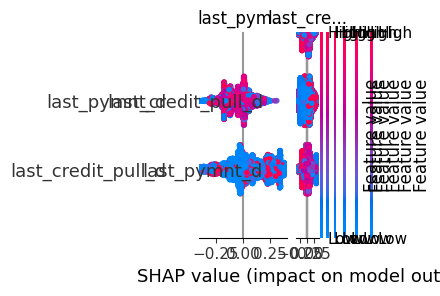

In [493]:
# SHAP values for Decision Tree
explainer_dt = shap.TreeExplainer(dt_model,
                                  data = X_val_selected_dict['decision tree'])

shap_values_dt = explainer_dt.shap_values(X_val_selected_dict['decision tree'])

shap.summary_plot(shap_values_dt[:,:,0],
                  X_val_selected_dict['decision tree'],
                  max_display = 2)

plt.show()
display(plt.gcf())


In [490]:
print(shap_values_dt.shape)
print(X_val_selected_dict['decision tree'].shape)

(5154, 4, 2)
(5154, 4)


In [ ]:
# SHAP values for Decision Tree
explainer_dt = shap.TreeExplainer(decision_tree_model)
shap_values_dt = explainer_dt.shap_values(X_test)

# SHAP values for Logistic Regression
explainer_lr = shap.LinearExplainer(logistic_model, X_train_selected)
shap_values_lr = explainer_lr.shap_values(X_test_selected)

# SHAP values for Neural Network
explainer_nn = shap.DeepExplainer(neural_network_model, X_train_tensor)
shap_values_nn = explainer_nn.shap_values(X_test_tensor)

# SHAP summary plots for each model
print("SHAP Summary Plot for Decision Tree")
shap.summary_plot(shap_values_dt[1], X_test)

print("SHAP Summary Plot for Logistic Regression")
shap.summary_plot(shap_values_lr[1], X_test)

print("SHAP Summary Plot for Neural Network")
shap.summary_plot(shap_values_nn[1], X_test_tensor)